# Multi Emotion Detector - Keras

Author: Sethu Iyer


Techniques: Transfer Learning


Dataset collected using [Bulk Bing Image Downloader](https://github.com/ostrolucky/Bulk-Bing-Image-downloader)

In [1]:
#Step 1: Use Pretrained VGG16 network and extract the features.

from keras.applications import VGG16,imagenet_utils
from keras.preprocessing.image import load_img,img_to_array
import numpy as np
from keras.models import Model
preprocess = imagenet_utils.preprocess_input
model = VGG16(weights="imagenet")
new_model = Model(inputs=model.input,outputs=model.layers[21].output)

def convert_img_to_vector(img_path):
    image = load_img(img_path,target_size=(224,224))
    image = img_to_array(image)
    image = np.expand_dims(image,axis=0)
    image = preprocess(image)
    return image

def get_image_feature(img_path):
    feats = np.transpose(new_model.predict(convert_img_to_vector(img_path)))
    return feats

Using TensorFlow backend.


In [2]:
#2. Import the custom dataset and compute the top 4096 features.
import glob
train_angry = glob.glob('./data/train/angry_face/*')
train_disgust = glob.glob('./data/train/disgust_face/*')
train_happy = glob.glob('./data/train/happy_face/*')
train_sad = glob.glob('./data/train/sad_face/*')
train_scared = glob.glob('./data/train/scared_face/*')
train_shocked = glob.glob('./data/train/shocked_face/*')

total_train = len(train_angry) + len(train_disgust) + len(train_happy) + len(train_sad) + len(train_scared) + len(train_shocked)

val_angry = glob.glob('./data/validation/angry_face/*')
val_disgust = glob.glob('./data/validation/disgust_face/*')
val_happy = glob.glob('./data/validation/happy_face/*')
val_sad = glob.glob('./data/validation/sad_face/*')
val_scared = glob.glob('./data/validation/scared_face/*')
val_shocked = glob.glob('./data/validation/shocked_face/*')

total_val = len(val_happy) + len(val_sad) + len(val_angry) + len(val_disgust) + len(val_scared) + len(val_shocked)

feats_train_angry = np.array([[get_image_feature(filename)] for filename in train_angry])
feats_train_disgust = np.array([[get_image_feature(filename)] for filename in train_disgust])
feats_train_happy = np.array([[get_image_feature(filename)] for filename in train_happy])
feats_train_sad = np.array([[get_image_feature(filename)] for filename in train_sad])
feats_train_scared = np.array([[get_image_feature(filename)] for filename in train_scared])
feats_train_shocked = np.array([[get_image_feature(filename)] for filename in train_shocked])
feats_train = np.hstack([feats_train_angry,feats_train_disgust,feats_train_happy,feats_train_sad,feats_train_scared,feats_train_shocked]).reshape(-1,4096)
del feats_train_happy,feats_train_sad, feats_train_angry, feats_train_disgust,feats_train_scared,feats_train_shocked  #we dont require

feats_val_angry = np.array([[get_image_feature(filename)] for filename in val_angry])
feats_val_disgust = np.array([[get_image_feature(filename)] for filename in val_disgust])
feats_val_happy = np.array([[get_image_feature(filename)] for filename in val_happy])
feats_val_sad = np.array([[get_image_feature(filename)] for filename in val_sad])
feats_val_scared = np.array([[get_image_feature(filename)] for filename in val_scared])
feats_val_shocked = np.array([[get_image_feature(filename)] for filename in val_shocked])
feats_val = np.hstack([feats_val_angry,feats_val_disgust,feats_val_happy,feats_val_sad,feats_val_scared,feats_val_shocked]).reshape(-1,4096)
del feats_val_happy,feats_val_sad,feats_val_angry,feats_val_disgust,feats_val_scared,feats_val_shocked  #we dont require

print(feats_train.shape,feats_val.shape)

(354, 4096) (12, 4096)


In [3]:
#3. Define out model.
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import rmsprop
model = Sequential()
model.add(Dense(256, activation="relu", input_shape=(4096,), kernel_initializer="normal"))
model.add(Dense(64, activation="relu", kernel_initializer="normal"))
model.add(Dense(16, activation="relu", kernel_initializer="normal"))
model.add(Dense(6, activation="softmax", kernel_initializer="normal")) # We have 6 number of classes.
opt = rmsprop(lr=0.0001,decay=1e-6)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [4]:
#4. Defining our Output label.

#First, lets one hot encode the label.
angry_encoding=[1,0,0,0,0,0]
disgust_encoding=[0,1,0,0,0,0]
happy_encoding=[0,0,1,0,0,0]
sad_encoding=[0,0,0,1,0,0]
scared_encoding=[0,0,0,0,1,0]
shocked_encoding=[0,0,0,0,0,1]

train_labels = np.array([angry_encoding * 59 + 
                         disgust_encoding * 59 +
                        happy_encoding * 59 +
                        sad_encoding * 59 +
                        scared_encoding * 59 +
                        shocked_encoding * 59]).reshape(-1,6)  #59 examples of each
validation_labels = np.array([angry_encoding * 2 +
                             disgust_encoding * 2 +
                             happy_encoding * 2 +
                             sad_encoding * 2 +
                             scared_encoding * 2 +
                             shocked_encoding * 2]).reshape(-1,6) #2 validation happy image and sad image.
print(train_labels.shape,validation_labels.shape)

(354, 6) (12, 6)


In [5]:
#5.train our model
import keras
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=0, mode='auto')
model.fit(feats_train,
          train_labels,
          epochs=15,
          batch_size=16,
          validation_data=(feats_val,validation_labels),
          verbose=1,
         callbacks=[earlyStopping])
print('Training Completed!')

Train on 354 samples, validate on 12 samples
Epoch 1/15
354/354 [==============================] - 0s - loss: 1.7924 - acc: 0.1554 - val_loss: 1.7765 - val_acc: 0.2500
Epoch 2/15
354/354 [==============================] - 0s - loss: 1.7662 - acc: 0.2542 - val_loss: 1.7701 - val_acc: 0.1667
Epoch 3/15
354/354 [==============================] - ETA: 0s - loss: 1.7457 - acc: 0.300 - 0s - loss: 1.7437 - acc: 0.3107 - val_loss: 1.7566 - val_acc: 0.2500
Epoch 4/15
354/354 [==============================] - 0s - loss: 1.7186 - acc: 0.3672 - val_loss: 1.7522 - val_acc: 0.25000.359
Epoch 5/15
354/354 [==============================] - 0s - loss: 1.6914 - acc: 0.4181 - val_loss: 1.7460 - val_acc: 0.2500
Epoch 6/15
354/354 [==============================] - 0s - loss: 1.6601 - acc: 0.4548 - val_loss: 1.7360 - val_acc: 0.2500
Epoch 7/15
354/354 [==============================] - 0s - loss: 1.6291 - acc: 0.4831 - val_loss: 1.7263 - val_acc: 0.3333
Epoch 8/15
354/354 [==============================]

In [6]:
%matplotlib inline
from matplotlib.pyplot import imshow
from scipy.misc import imread
def predict_mood(img_path):
    imshow(imread(img_path))
    decode_dict={0: 'Angry', 1: 'Disgusted', 2: 'Happy', 3:'Sad', 4:'Scared',5:'Shocked'}
    feats = get_image_feature(img_path)
    feats = feats.reshape(-1,4096)
    probab = model.predict_proba(feats,verbose=0)
    top_2 = probab[0].argpartition(-2)[-2:][::-1]
    percent_high = np.around(100*probab[0][top_2[0]],decimals=2)
    percent_secondhigh = np.around(100*probab[0][top_2[1]],decimals=2)

    print('The person in the image is '+str(percent_high)+' % '+decode_dict[top_2[0]] +' and '+str(percent_secondhigh)+' % '+decode_dict[top_2[1]])

The person in the image is 29.62 % Scared and 22.09 % Sad


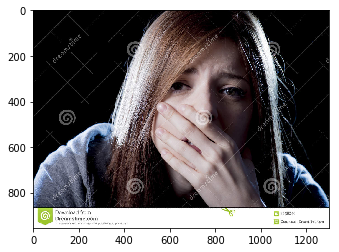

In [7]:
predict_mood('test1.jpg')

The person in the image is 22.68 % Shocked and 19.89 % Sad


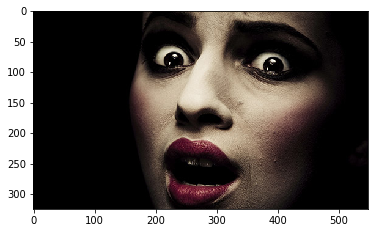

In [8]:
predict_mood('test2.jpg')

The person in the image is 23.79 % Angry and 22.44 % Sad


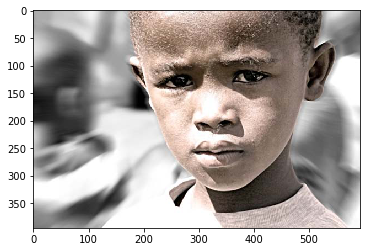

In [9]:
predict_mood('test3.jpg')

The person in the image is 21.62 % Sad and 21.09 % Disgusted


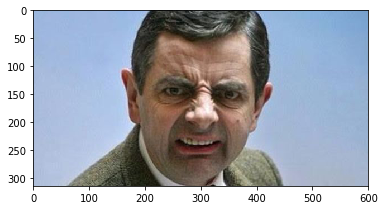

In [12]:
predict_mood('test4.jpg')